In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re

import sagemaker
from sagemaker import get_execution_role

In [2]:
role = sagemaker.get_execution_role()


In [3]:
#initiate s3 resource
s3 = boto3.resource('s3')

# select bucket
my_bucket = s3.Bucket('sagemaker-studio-i8kf84zy9f')
def downloadDirectoryFroms3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucketName) 
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        if (obj.key == remoteDirectoryName + "/"):
            continue
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key)
        
downloadDirectoryFroms3('sagemaker-studio-i8kf84zy9f', 'HF_Prop_cal')
downloadDirectoryFroms3('sagemaker-studio-i8kf84zy9f', 'oil')

In [30]:
training_set_path = "./training_set.txt" # path to the file describing training set
oil_files_list = ["oil/oil-0.csv",
                  "oil/oil-0(1).csv"]
oil_classifier = 'SVM' # or 'IsolationForest'
max_oil_samples = 200000
remove_negative_signals = True
ignore_time = True
features_to_train = ['FSC-H','SSC-H','BL-530-H','BL-586-H','BL-615-H','BL-660-H','BL-695-H','BL-725-H','BL-780-H','RL-660-H','RL-695-H','RL-725-H','RL-780-H','VL-445-H',
                     'VL-530-H','VL-586-H','VL-615-H','VL-660-H','VL-695-H','VL-725-H','VL-780-H','YL-586-H','YL-615-H','YL-660-H','YL-695-H','YL-725-H','YL-780-H']

def filter_data(df, features_list): 
    df = df[features_list]
    if remove_negative_signals:
        for feature in features_list:
            df = df[df[feature] > 0]
    else:
        for feature in features_list:
            df = df[df[feature] != 0]


    X = np.array(df)
    negative_mask = X < 0
    X = np.abs(X)
    X = np.log10(X)
    X[negative_mask] *= -1

    #X = np.cbrt(X)

    df = pd.DataFrame(X, columns=features_list)
    return df


def load_training_set(path):
    df = pd.read_csv(path)

    arr = np.asarray(df)
    filenames = arr[:, 0]
    marker_names = arr[:, 1]
    return filenames, marker_names


def load_markers(filename, oil_clf):
    df = pd.read_csv(filename)
    print("From file ", filename, " loaded dataframe of size: ", df.shape)

    # drop events before start_time
    if not ignore_time and "Time" in df.keys():
        ind = df["Time"] > start_time
        df = df[ind]

    # only interesting features
    df = filter_data(df, features_to_train)

    #df = filter_marker(df, features_to_train, oil_clf)
    print("After filtering marker data frame size: ", df.shape)

    return df


def create_trainig_set(): 
    print("load oil markers...") 
    #oil_clf, oil_data = train_oil_model(oil_files_list) 
    #joblib.dump(oil_clf, "oil_model.pkl")

    filenames, marker_names = load_training_set(training_set_path)
    print(filenames)

    X_df = load_markers(filenames[0], None)
    X = X_df.values

    label = 0

    (nsamples, nfeatures) = X.shape
    y = np.full((nsamples, 1), label)

    label += 1
    for i in range(1, len(filenames)):
        X_df = load_markers(filenames[i], None)
        (nsamples, nfeatures) = X_df.shape
        y1 = np.full((nsamples, 1), label)

        X = np.vstack((X, X_df.values))
        y = np.vstack((y, y1))

        i += 1
        label += 1


    # add_oil_to_train_set
#     nsamples = len(oil_data)
#     y1 = np.full((nsamples, 1), label)

#     X = np.vstack((X, oil_data.values))
#     y = np.vstack((y, y1))

    c, r = y.shape
    y = y.reshape(c, )

    return X, y

X, y = create_trainig_set()

load oil markers...
['HF_Prop_cal/201.csv' 'HF_Prop_cal/202.csv' 'HF_Prop_cal/203.csv'
 'HF_Prop_cal/205.csv' 'HF_Prop_cal/206.csv' 'HF_Prop_cal/209.csv'
 'HF_Prop_cal/210.csv' 'HF_Prop_cal/212.csv' 'HF_Prop_cal/213.csv'
 'HF_Prop_cal/214.csv']
From file  HF_Prop_cal/201.csv  loaded dataframe of size:  (5115, 29)
After filtering marker data frame size:  (4753, 27)
From file  HF_Prop_cal/202.csv  loaded dataframe of size:  (2336, 29)
After filtering marker data frame size:  (2174, 27)
From file  HF_Prop_cal/203.csv  loaded dataframe of size:  (9533, 29)
After filtering marker data frame size:  (9006, 27)
From file  HF_Prop_cal/205.csv  loaded dataframe of size:  (2750, 29)
After filtering marker data frame size:  (2724, 27)
From file  HF_Prop_cal/206.csv  loaded dataframe of size:  (3122, 29)
After filtering marker data frame size:  (3122, 27)
From file  HF_Prop_cal/209.csv  loaded dataframe of size:  (3458, 29)
After filtering marker data frame size:  (3446, 27)
From file  HF_Prop_cal/

In [66]:
from sagemaker import PCA
num_components=8
bucket = 'sagemaker-studio-i8kf84zy9f'

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path='s3://'+ bucket +'/pca/',
             num_components=num_components)

In [67]:
%%time
pca_SM.fit(pca_SM.record_set(X))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-04 08:47:13 Starting - Starting the training job...
2020-08-04 08:47:15 Starting - Launching requested ML instances.........
2020-08-04 08:48:47 Starting - Preparing the instances for training......
2020-08-04 08:50:03 Downloading - Downloading input data...
2020-08-04 08:50:44 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/04/2020 08:50:47 INFO 140257548547904] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[08/04/2020 08:50:47 INFO 140257548547904] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'27', u'mini_batch_s

In [68]:
job_name = pca_SM.latest_training_job.name
model_key = "pca/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

In [69]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [70]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [72]:
s.iloc[4:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.982534
dtype: float32

In [54]:
s_6=s.iloc[20:,:]
v_6=v.iloc[:,20:]
v_6.columns=[0,1,2,3,4,5]

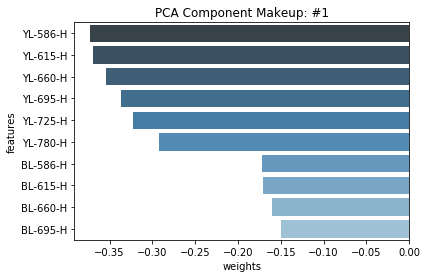

In [60]:
component_num=1
import seaborn as sns

first_comp = v_6[6-component_num]
comps = pd.DataFrame(list(zip(first_comp, features_to_train)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [73]:
# number of components
n_pcs= 8

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(v[i]).argmax() for i in range(n_pcs)]

initial_feature_names = features_to_train

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,RL-780-H
1,PC2,SSC-H
2,PC3,FSC-H
3,PC4,BL-530-H
4,PC5,VL-445-H
5,PC6,VL-445-H
6,PC7,RL-695-H
7,PC8,YL-586-H
